In [1]:
import pandas as pd
import geojson
import geopandas as gpd

# Convert your CSV data to GeoJSON
This script reads a CSV file containing incident data and converts it to GeoJSON format.
> I didn't commit the samples.csv due to private data.

In [2]:
# Load the CSV data into a DataFrame
csv_file = "data/sample_incidents.csv"  # Replace with the path to your CSV file
df = pd.read_csv(csv_file)

# Create a GeoJSON FeatureCollection
features = []

for index, row in df.iterrows():
    feature = geojson.Feature(
        geometry=geojson.Point((row["Longitude"], row["Latitude"])),
        properties={
            "incident_id": index,
            "lat": row["Latitude"],
            "lon": row["Longitude"],
            "cell_id": row["cell_id"],
            "Time": row["Time"],
            "weekday": row["weekday"],
            "historical_density": row["historical_density"],
            "xd": row["xd"],
            "weighted_population": row["weighted_population"],
            "weighted_housing_units": row["weighted_housing_units"],
            "cluster_label": row["cluster_label"],
            "speed": row["speed"],
            "reference_speed": row["reference_speed"],
            "historical_average_speed": row["historical_average_speed"],
            "travel_time_minutes": row["travel_time_minutes"],
            "tempf": row["tempf"],
            "dewPt": row["dewPt"],
            "rh": row["rh"],
            "wdir_cardinal": row["wdir_cardinal"],
            "wspd": row["wspd"],
            "gust": row["gust"],
            "pressure": row["pressure"],
            "precip": row["precip"],
            "wx_phrase": row["wx_phrase"],
            "oid": row["oid"],
            "IncidentNumber": row["IncidentNumber"],
            "AlarmDate": row["AlarmDate"],
            "PSAPDate": row["PSAPDate"],
            "time_bet": row["time_bet"],
            "window_1": row["window_1"],
            "window_2": row["window_2"],
            "window_3": row["window_3"],
            "window_4": row["window_4"],
            "window_5": row["window_5"],
            "original_historical_density": row["original_historical_density"],
        },
    )
    features.append(feature)

geojson_data = geojson.FeatureCollection(features)

# Save the GeoJSON to a file
output_file = "data/incidents.geojson"  # Replace with your desired output file path
with open(output_file, "w") as f:
    geojson.dump(geojson_data, f)

print(f"GeoJSON file saved to {output_file}")

GeoJSON file saved to data/incidents.geojson


<Axes: >

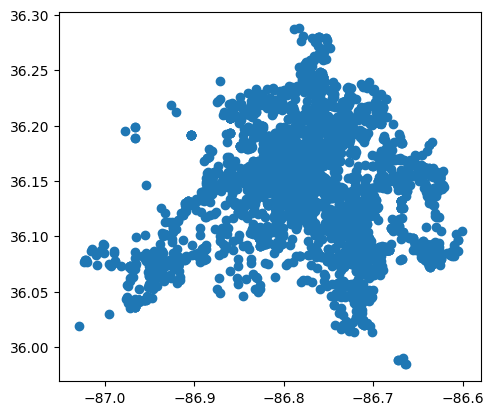

In [3]:

# pandas show all column
pd.set_option("display.max_columns", None)
df = gpd.read_file(output_file)
df.plot()

In [4]:
from processor import save_p_median_solution, add_p_via_mip_multi, fill_solution_X, compute_nearest_assignments
import joblib
import geopandas as gpd
import geojson
import pandas as pd
import json
import os
with open(os.path.join("data", "grids.geojson")) as f:
    grid_data = json.load(f)
with open(os.path.join("data", "incidents.geojson")) as f:
    point_data = json.load(f)
with open(os.path.join("data", "firestations.geojson")) as f:
    station_data = json.load(f)
grids    = gpd.GeoDataFrame.from_features(grid_data,    crs="EPSG:4326")
incidents= gpd.GeoDataFrame.from_features(point_data,   crs="EPSG:4326")
fire_stations = gpd.GeoDataFrame.from_features(station_data, crs="EPSG:4326")
# gdf_markers = gpd.GeoDataFrame.from_features(markers, crs="EPSG:4326")
# gdf_markers['FacilityName'] = (
#     gdf_markers['station_id']
#       .apply(lambda x: f"Station {x:.2f}")
# )
# fire_stations=pd.concat([fire_stations,gdf_markers[['geometry','FacilityName']]],ignore_index=True)
fire_stations= gpd.sjoin(fire_stations, grids, how='inner', predicate='within')
L=list(grids['cell_id'])
X_exist= list(fire_stations['cell_id'])

E = list(range(len(incidents)))
a= joblib.load("data/a_sub.pkl")
d= joblib.load("data/first_half_by_i.pkl")
# assignments
m, X, Y, b = add_p_via_mip_multi(E,L,a,d,X_exist,p_add=0, alpha=0)
sol_X_vals,sol_Y_assign=save_p_median_solution( X, Y, E, L)
sol_X_vals.reset_index(inplace=True,names='location')
sol_X = fill_solution_X(sol_X_vals, grids, fire_stations)
sol_X= gpd.GeoDataFrame(sol_X, geometry='geometry')
sol_X.crs= 'EPSG:4326'
sol_Y= compute_nearest_assignments(sol_Y_assign, incidents, sol_X)
sol_Y=sol_Y.sjoin(grids, how='inner', predicate='within')

cell_to_station=sol_Y.drop_duplicates(subset=['FacilityName','assigned_cell_id'], keep='first')[['FacilityName','assigned_cell_id']]
incidents_to_station=sol_Y.drop_duplicates(subset=['demand','FacilityName'], keep='first')[['demand','FacilityName','assigned_cell_id','cell_id']]
groups=sol_Y.groupby('FacilityName')
travel_times={}
for name, group in groups:
    travel_time=[]
    for i,row in group.iterrows():
        travel_time.append(min(float(d[row['demand'],row['assigned_cell_id']]),20))
    travel_times[name]=travel_time
    
    
travel_times_df=pd.Series(travel_times, name='travel_times').to_frame()
travel_times_df.reset_index(inplace=True,names='FacilityName')
fire_stations=pd.merge(fire_stations, travel_times_df, on='FacilityName', how='left')
incidents_to_station.rename(columns={'demand':'incident_id'}, inplace=True)
fire_stations.drop(columns=['geometry'], inplace=True)


Set parameter NonConvex to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B2082)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Non-default parameters:
NonConvex  0

Optimize a model with 2744806 rows, 2740800 columns and 8221238 nonzeros
Model fingerprint: 0x577fb359
Variable types: 0 continuous, 2740800 integer (2740200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-13, 6e+03]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 107607.41836
Presolve removed 2740240 rows and 2567292 columns
Presolve time: 0.94s
Presolved: 4566 rows, 173508 columns, 173508 nonzeros
Variable types: 0 continuous, 173508 integer (173508 binary)
Performing another presolve...
Presolve removed 0 rows and 168942 columns
Presolve time: 0.02s
Found heuristic solution: objective 63982.069896

Explored 1 nodes (0 simplex it

/Users/ammarbinzulqarnain/Documents/Scope Lab/Project/fire_demo/processor.py:230: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance'] = gdf.geometry.distance(gdf['incident_geom'])


In [ ]:

markers={'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'type': 'marker', '_leaflet_id': 15795, 'station_id': 2}, 'geometry': {'type': 'Point', 'coordinates': [-86.9121551513672, 36.27638594874375]}}, {'type': 'Feature', 'properties': {'type': 'marker', '_leaflet_id': 15824, 'station_id': 42}, 'geometry': {'type': 'Point', 'coordinates': [-86.75148010253906, 36.348314860643015]}}, {'type': 'Feature', 'properties': {'type': 'marker', '_leaflet_id': 15841, 'station_id': 43}, 'geometry': {'type': 'Point', 'coordinates': [-86.5935516357422, 36.10736936266137]}}]}
fire_stations = gpd.GeoDataFrame.from_features(station_data, crs="EPSG:4326")




In [5]:
fire_stations

,OBJECTID,FacilityName,Address,City,State,ZipCode,GLOBALID,index_right,cell_id,x,y,travel_times
0,1,Station 39,1247 South Dickerson Rd,Goodlettsvi,TN,37072,eac3496b-ab7d-4f6a-ad14-bf5ada67676a,362,362,-86.744362,36.293403,"[7.885000000000001, 5.614999999999999, 10.0283..."
1,2,Station 31,415 Douglas Ave,Madison,TN,37115,02eb0d96-6a2d-46f0-8c6e-b5f116da0127,417,417,-86.708271,36.264611,[5.8149999999999995]
2,3,Station 36,1000 Donelson St,Old Hickory,TN,37138,c7a64605-5809-417b-8cf0-eee80a956583,492,492,-86.654544,36.264914,NaN
3,4,Station 25,2589 Whites Creek Pike,Nashville,TN,37207,2524f01d-752e-4c45-a598-6a5d899fb770,276,276,-86.797379,36.220544,"[5.593333333333334, 7.743333333333334, 6.01000..."
4,5,Station 01,130 Broadmoor Ave,Nashville,TN,37207,fa10573a-b069-4f65-9663-0c4ecc4e2b0d,329,329,-86.761720,36.235278,"[3.57, 4.138333333333334, 4.0, 5.745, 2.508333..."
5,6,Station 29,4201 Gallatin Rd,Nashville,TN,37216,c275d6b6-f9a5-48ee-bce3-3e4d1f303abc,386,386,-86.725782,36.220995,"[1.5450000000000002, 19.651666666666664, 2.818..."
6,7,Station 22,2781 Pennington Bend,Nashville,TN,37214,3ae8b970-76ba-4f48-8f05-610dde07b18a,439,439,-86.689983,36.221205,"[2.235, 6.5216666666666665, 6.5216666666666665..."
7,8,Station 24,3851 Clarksville Hwy,Nashville,TN,37218,1c509921-fef9-4d43-8108-9a4f124982a8,228,228,-86.833024,36.205798,"[5.925, 5.663333333333333, 5.663333333333333, ..."
8,9,Station 18,1151 East Cahal Ave,Nashville,TN,37206,033c5e7b-f7fc-435b-aba2-ca37c2d9ac4d,355,355,-86.743409,36.191879,"[3.9716666666666662, 5.895, 2.48, 2.5216666666..."
9,11,Station 11,1745 18th Ave N,Nashville,TN,37208,a6dc54b4-8690-45d3-928d-0ea611ba3025,250,250,-86.814831,36.176914,"[1.79, 3.8866666666666663, 4.965, 5.5916666666..."


In [ ]:
gdf_markers['FacilityName'] = (
    gdf_markers['station_id']
      .apply(lambda x: f"Station {x:.2f}")
)

In [17]:
pd.concat([fire_stations,gdf_markers[['geometry','FacilityName']]],ignore_index=True)

,geometry,OBJECTID,FacilityName,Address,City,State,ZipCode,GLOBALID
0,POINT (-86.73861 36.29108),1.0,Station 39,1247 South Dickerson Rd,Goodlettsvi,TN,37072,eac3496b-ab7d-4f6a-ad14-bf5ada67676a
1,POINT (-86.71579 36.25899),2.0,Station 31,415 Douglas Ave,Madison,TN,37115,02eb0d96-6a2d-46f0-8c6e-b5f116da0127
2,POINT (-86.64802 36.26449),3.0,Station 36,1000 Donelson St,Old Hickory,TN,37138,c7a64605-5809-417b-8cf0-eee80a956583
3,POINT (-86.80144 36.21618),4.0,Station 25,2589 Whites Creek Pike,Nashville,TN,37207,2524f01d-752e-4c45-a598-6a5d899fb770
4,POINT (-86.75675 36.2294),5.0,Station 01,130 Broadmoor Ave,Nashville,TN,37207,fa10573a-b069-4f65-9663-0c4ecc4e2b0d
5,POINT (-86.72609 36.22406),6.0,Station 29,4201 Gallatin Rd,Nashville,TN,37216,c275d6b6-f9a5-48ee-bce3-3e4d1f303abc
6,POINT (-86.68844 36.2167),7.0,Station 22,2781 Pennington Bend,Nashville,TN,37214,3ae8b970-76ba-4f48-8f05-610dde07b18a
7,POINT (-86.84102 36.20359),8.0,Station 24,3851 Clarksville Hwy,Nashville,TN,37218,1c509921-fef9-4d43-8108-9a4f124982a8
8,POINT (-86.73748 36.19657),9.0,Station 18,1151 East Cahal Ave,Nashville,TN,37206,033c5e7b-f7fc-435b-aba2-ca37c2d9ac4d
9,POINT (-86.81118 36.17919),11.0,Station 11,1745 18th Ave N,Nashville,TN,37208,a6dc54b4-8690-45d3-928d-0ea611ba3025


In [ ]:
fire_stations

,geometry,OBJECTID,FacilityName,Address,City,State,ZipCode,GLOBALID
0,POINT (-86.73861 36.29108),1,Station 39,1247 South Dickerson Rd,Goodlettsvi,TN,37072,eac3496b-ab7d-4f6a-ad14-bf5ada67676a
1,POINT (-86.71579 36.25899),2,Station 31,415 Douglas Ave,Madison,TN,37115,02eb0d96-6a2d-46f0-8c6e-b5f116da0127
2,POINT (-86.64802 36.26449),3,Station 36,1000 Donelson St,Old Hickory,TN,37138,c7a64605-5809-417b-8cf0-eee80a956583
3,POINT (-86.80144 36.21618),4,Station 25,2589 Whites Creek Pike,Nashville,TN,37207,2524f01d-752e-4c45-a598-6a5d899fb770
4,POINT (-86.75675 36.2294),5,Station 01,130 Broadmoor Ave,Nashville,TN,37207,fa10573a-b069-4f65-9663-0c4ecc4e2b0d
5,POINT (-86.72609 36.22406),6,Station 29,4201 Gallatin Rd,Nashville,TN,37216,c275d6b6-f9a5-48ee-bce3-3e4d1f303abc
6,POINT (-86.68844 36.2167),7,Station 22,2781 Pennington Bend,Nashville,TN,37214,3ae8b970-76ba-4f48-8f05-610dde07b18a
7,POINT (-86.84102 36.20359),8,Station 24,3851 Clarksville Hwy,Nashville,TN,37218,1c509921-fef9-4d43-8108-9a4f124982a8
8,POINT (-86.73748 36.19657),9,Station 18,1151 East Cahal Ave,Nashville,TN,37206,033c5e7b-f7fc-435b-aba2-ca37c2d9ac4d
9,POINT (-86.81118 36.17919),11,Station 11,1745 18th Ave N,Nashville,TN,37208,a6dc54b4-8690-45d3-928d-0ea611ba3025


In [16]:
incidents_to_station

,incident_id,FacilityName,assigned_cell_id,cell_id
0,0,Station 12,352,323
1,1,Station 11,250,250
2,2,Station 08,270,270
3,3,Station 09,296,297
4,4,Station 18,355,384
...,...,...,...,...
4562,4562,Station 19,249,249
4563,4563,Station 37,80,98
4564,4564,Station 24,228,227
4565,4565,Station 19,249,272


In [6]:
incidents_to_station.to_csv("data/incidents_to_station.csv", index=False)
cell_to_station.to_csv("data/cell_to_station.csv", index=False)

fire_stations.to_csv("data/fire_stations.csv", index=False)

,OBJECTID,FacilityName,Address,City,State,ZipCode,GLOBALID,index_right,cell_id,x,y,travel_time
0,1,Station 39,1247 South Dickerson Rd,Goodlettsvi,TN,37072,eac3496b-ab7d-4f6a-ad14-bf5ada67676a,362,362,-86.744362,36.293403,6.159479
1,2,Station 31,415 Douglas Ave,Madison,TN,37115,02eb0d96-6a2d-46f0-8c6e-b5f116da0127,417,417,-86.708271,36.264611,5.815000
2,3,Station 36,1000 Donelson St,Old Hickory,TN,37138,c7a64605-5809-417b-8cf0-eee80a956583,492,492,-86.654544,36.264914,NaN
3,4,Station 25,2589 Whites Creek Pike,Nashville,TN,37207,2524f01d-752e-4c45-a598-6a5d899fb770,276,276,-86.797379,36.220544,3.983456
4,5,Station 01,130 Broadmoor Ave,Nashville,TN,37207,fa10573a-b069-4f65-9663-0c4ecc4e2b0d,329,329,-86.761720,36.235278,3.990316
5,6,Station 29,4201 Gallatin Rd,Nashville,TN,37216,c275d6b6-f9a5-48ee-bce3-3e4d1f303abc,386,386,-86.725782,36.220995,3.025141
6,7,Station 22,2781 Pennington Bend,Nashville,TN,37214,3ae8b970-76ba-4f48-8f05-610dde07b18a,439,439,-86.689983,36.221205,5.489906
7,8,Station 24,3851 Clarksville Hwy,Nashville,TN,37218,1c509921-fef9-4d43-8108-9a4f124982a8,228,228,-86.833024,36.205798,5.767750
8,9,Station 18,1151 East Cahal Ave,Nashville,TN,37206,033c5e7b-f7fc-435b-aba2-ca37c2d9ac4d,355,355,-86.743409,36.191879,3.035051
9,11,Station 11,1745 18th Ave N,Nashville,TN,37208,a6dc54b4-8690-45d3-928d-0ea611ba3025,250,250,-86.814831,36.176914,4.144246


,incident_id,FacilityName,assigned_cell_id
0,0,Station 12,352
1,1,Station 11,250
2,2,Station 08,270
3,3,Station 09,296
4,4,Station 18,355
...,...,...,...
4562,4562,Station 19,249
4563,4563,Station 37,80
4564,4564,Station 24,228
4565,4565,Station 19,249


In [ ]:
travel_times_df.reset_index(inplace=True,names='FacilityName')

In [ ]:
fire_stations=pd.merge(fire_stations, travel_times_df, on='FacilityName', how='left')

In [ ]:
fire_stations

,geometry,OBJECTID,FacilityName,Address,City,State,ZipCode,GLOBALID,index_right,cell_id,x,y,travel_time
0,POINT (-86.73861 36.29108),1,Station 39,1247 South Dickerson Rd,Goodlettsvi,TN,37072,eac3496b-ab7d-4f6a-ad14-bf5ada67676a,362,362,-86.744362,36.293403,6.159479
1,POINT (-86.71579 36.25899),2,Station 31,415 Douglas Ave,Madison,TN,37115,02eb0d96-6a2d-46f0-8c6e-b5f116da0127,417,417,-86.708271,36.264611,5.815000
2,POINT (-86.64802 36.26449),3,Station 36,1000 Donelson St,Old Hickory,TN,37138,c7a64605-5809-417b-8cf0-eee80a956583,492,492,-86.654544,36.264914,NaN
3,POINT (-86.80144 36.21618),4,Station 25,2589 Whites Creek Pike,Nashville,TN,37207,2524f01d-752e-4c45-a598-6a5d899fb770,276,276,-86.797379,36.220544,3.983456
4,POINT (-86.75675 36.2294),5,Station 01,130 Broadmoor Ave,Nashville,TN,37207,fa10573a-b069-4f65-9663-0c4ecc4e2b0d,329,329,-86.761720,36.235278,3.990316
5,POINT (-86.72609 36.22406),6,Station 29,4201 Gallatin Rd,Nashville,TN,37216,c275d6b6-f9a5-48ee-bce3-3e4d1f303abc,386,386,-86.725782,36.220995,3.025141
6,POINT (-86.68844 36.2167),7,Station 22,2781 Pennington Bend,Nashville,TN,37214,3ae8b970-76ba-4f48-8f05-610dde07b18a,439,439,-86.689983,36.221205,5.489906
7,POINT (-86.84102 36.20359),8,Station 24,3851 Clarksville Hwy,Nashville,TN,37218,1c509921-fef9-4d43-8108-9a4f124982a8,228,228,-86.833024,36.205798,5.767750
8,POINT (-86.73748 36.19657),9,Station 18,1151 East Cahal Ave,Nashville,TN,37206,033c5e7b-f7fc-435b-aba2-ca37c2d9ac4d,355,355,-86.743409,36.191879,3.035051
9,POINT (-86.81118 36.17919),11,Station 11,1745 18th Ave N,Nashville,TN,37208,a6dc54b4-8690-45d3-928d-0ea611ba3025,250,250,-86.814831,36.176914,4.144246


In [ ]:
grids

,geometry,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,"POLYGON ((-87.03681 35.99742, -87.03681 35.989...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
1,"POLYGON ((-87.03682 36.01193, -87.03681 35.997...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
2,"POLYGON ((-87.03683 36.02644, -87.03682 36.011...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
3,"POLYGON ((-87.03683 36.04095, -87.03683 36.026...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
4,"POLYGON ((-87.03684 36.05546, -87.03683 36.040...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,"POLYGON ((-86.51839 36.09802, -86.53627 36.098...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
598,"POLYGON ((-86.53618 36.1126, -86.5361 36.12711...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
599,"MULTIPOLYGON (((-86.5361 36.12711, -86.53603 3...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
600,"POLYGON ((-86.51839 36.09802, -86.51589 36.098...",47,037,01639737,47037,0500000US47037,Davidson,Davidson County,06,H6,G4020,400,34980,None,C,1303999199,56424538,+36.1691287,-086.7847898
